# Interpretation of the Fitted Logistic Regression Model: Odds Ratio

## Dichotomous Indepentend Variable

Recall the definition of the logistic function 

$$
\pi(x) = \frac{e^{x'\beta}}{e^{1 + x'\beta}}
$$

with the logit

$$\begin{equation}
g(x) := ln \frac{\pi(x)}{1 + \pi(x)} = x'\beta.
\end{equation}$$.

The *odds ratio* is defined as:

$$
OR := \frac{\frac{\pi(1)}{1 - \pi(1)}}{\frac{\pi(0)}{1 - \pi(0)}}
$$

We look at a single dichotomous independent variable, e. g. $x \in \{0, 1\}$. The logit for this case is $g(x) = \beta_0 + \beta_1 x_1$ Now the odds ratio can be calculated and give

$$
OR = e^{\beta_1}
$$

Let's see how we can calculate the odds ratio in a other way with the help of a cross-classification table and then check it with the logistic regression model. We use the *sex* predictor in our data set:

In [1]:
source("helpers.r")
df <- get_training_df()
(cross_class_table  <- table(df$target, df$sex))

odds_ratio  <- function(df, variable) {
    cross_class_table  <- table(df$target, df[[variable]])
    or  <- (cross_class_table[2,2] / cross_class_table[1,2]) / (cross_class_table[2,1] / cross_class_table[1,1])
}

(or  <- odds_ratio(df, "sex"))

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_doubl

            
             Female Male
  no_disease     20   91
  disease        57   75

[1] 0.2891845

Remember that if the target is disease than $y = 1$ and if it is no disease $y = 0$. Also we say that $x = 1$ corresponds to male and $x = 0$ to female. The value of the odds ratio 

In [2]:
library(broom)
fit  <- glm(target ~ sex, data=df, family =binomial(link = "logit"))
(fit_result  <- tidy(fit))

term,estimate,std.error,statistic,p.value
(Intercept),1.047319,0.2598918,4.029827,5.581790e-05
sexMale,-1.240690,0.3030942,-4.093415,4.250655e-05


Now the calculation of the ods ratio is straight forward:

In [3]:
beta_1  <- fit_result$estimate[2]
(or_glm  <-  exp(beta_1))

[1] 0.2891845

The interpretation of this vaule is as follows: The occurrence of a heart disease is only about a third likely if you are male. My guess is that variables which odds ratio differes a lot from 1, have a good discriminantive power an hence models build with that variables will have good performance. There are two other variables in the data set that are dichotomous. One is *fbs* that decodes wether the person has a fasting blood sugar > 120 mg/dl or not. Here $x = 1$ means yes, the person has a high fasting blood sugar. Let's see if the OR is higher than 1:

In [4]:
(cross_class_table  <- table(df$target, df$fbs))
(or_fbs  <- odds_ratio(df, "fbs"))

            
              no yes
  no_disease  91  20
  disease    111  21

[1] 0.8608108

It is smaller than 1. The last dichotomous variable is *exang* and decodes wether a person has exercise induced angina. (x = 1 mean yes, x = 0 means no). So here i think the OR is higher than 1. 

In [5]:
(cross_class_table  <- table(df$target, df$exang))
(or_fbs  <- odds_ratio(df, "exang"))

            
              no yes
  no_disease  49  62
  disease    113  19

[1] 0.1328861

Ok so it's not. Maybe people with a heart disease don't do sport at all, so their is answer no to this question. (I don't know how the data was collected, but obviously this would be very important). So in summary:

$$
OR_{exang} <  OR_{sex} < OR_{fbs}.
$$

So let's see if this is also valid if we evalute the performance of the three single variable logistic regression models. 

Warning message:
"package 'MLmetrics' was built under R version 3.6.1"
Attaching package: 'MLmetrics'

The following objects are masked from 'package:caret':

    MAE, RMSE

The following object is masked from 'package:base':

    Recall


Attaching package: 'magrittr'

The following object is masked from 'package:purrr':

    set_names

The following object is masked from 'package:tidyr':

    extract



model,mean,median,sd
lg exang,0.7063270,0.7069181,0.05659305
lg fbs,0.5095529,0.5167333,0.07684761
lg sex,0.6261613,0.6048951,0.09354054


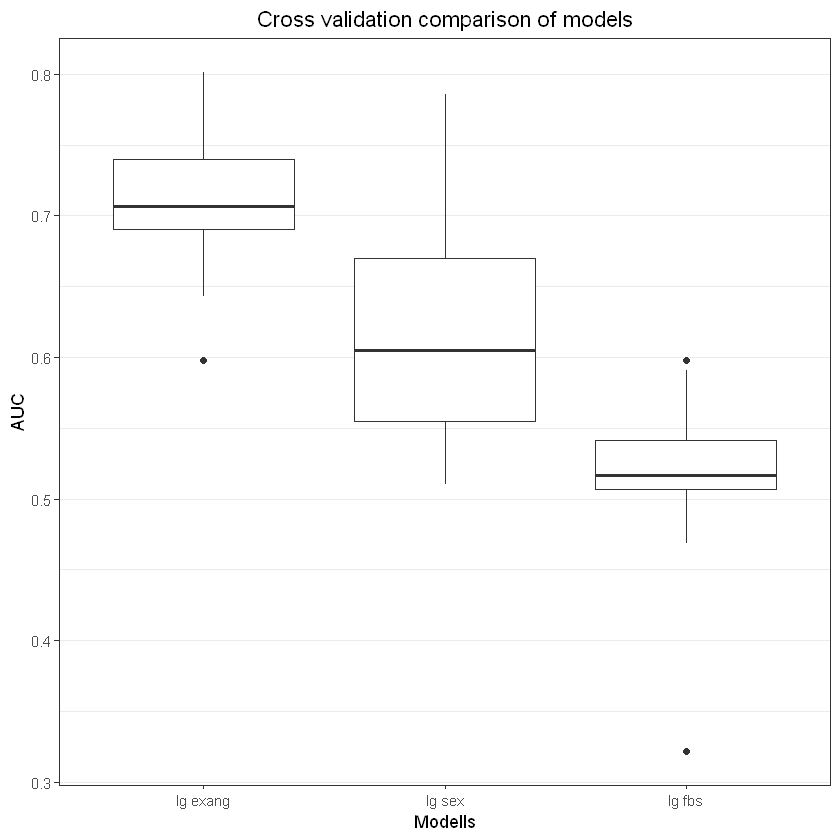

In [6]:
library(MLmetrics)
library(magrittr)

set.seed(25)
number_of_folds <- 10
folds <- createFolds(df$target, k = number_of_folds)

model_result <- tibble(model = vector("character"),
                       auc = vector("numeric"))
models <- c("lg exang", "lg sex", "lg fbs")

for(model in models){
    for(fold_index in c(1:number_of_folds)){
        training <- df[-folds[[fold_index]],]
        test <- df[folds[[fold_index]],]

        y_true <- ifelse(test$target == "no_disease", 0, 1)

        if (model == "lg exang") {
          fit <- glm(target ~ exang, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }
        if (model == "lg sex"){
          fit <- glm(target ~ sex, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }
        if (model == "lg fbs"){
          fit <- glm(target ~ fbs, data=training, family =binomial(link = "logit"))
          y_probabilities <- predict(fit, test,  type="response")
        }

        auc <- AUC(y_true = y_true, y_pred = y_probabilities)

        model_result %<>%
          add_row(model = model, auc = auc)

      }
}

model_result %>%
    group_by(model) %>%
    summarize(mean = mean(auc),
              median = median(auc),
              sd = sd(auc))

model_result %>%
    mutate(model = factor(model, levels = models)) %>%
    ggplot(aes(x = model, y = auc))+
    geom_boxplot() +
labs(
      x = "Modells",
      y = "AUC",
      title = "Cross validation comparison of models"
    ) + 
    theme_bw() + 
    theme(panel.grid.major.x = element_blank(),
          plot.title = element_text(hjust = 0.5)
          )

What a nice result. Note that $OR = 1  \Leftrightarrow \beta_1 = 0$, hence the predictor has no influence to the model.

## Polychotomous Independent Variable

Now the varable $x$ can have $k > 2$ different values. 